In [84]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np

#TSA tools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### 1. Some Forecasting Theory

We have:

$$y_{T+1}\lvert_{T} = \alpha_1y_T + \ldots + \alpha_p
y_{T+1 - p}$$
_Por lo tanto tenemos, $y_{T+1}\lvert_{T}$ es lo que nos da el modelo, mientras que $y_{T+1}$ es el valor real_

$$y_{T+1} - y_{T+1}\lvert_{T} = u_{T+1}$$

We define $u_t$ as the 1-step forecast error in period $t - 1$. 

The MSE of an h-step forecast (_es decir el error consecuencia de un forecast en t sobre los siguientes h elementos_)

$$\sigma^2_y(h) = \mathbb{E}((y_{T+h} - y_{T+h}\lvert_{T})^2) = \sigma^2\sum_{j = 0}^{h - 1}\phi_j^2$$

__If the process $y_t$ is Gaussian, that is $u_t\sim \mathcal{N}(0,\,\sigma_u^{2})$ the forecast errors are also normal.__ This result may be used to set up forecast intervals. 

_Hasta ahora todo ha sido a nivel teorico y "perfecto" por asi decirlo. Es decir, hemos supuesto que se realiza la mejor aproximacion posible teniendo datos hasta T. No se ha hecho ninguna suposicion sobre las observaciones o sobre la aproximacion de los parametros._

### 2. Example: Analyzing univariate Time Series



#### Step 1: Visualizing Data

_Vamos a visualizar la serie temporal en cuestion_

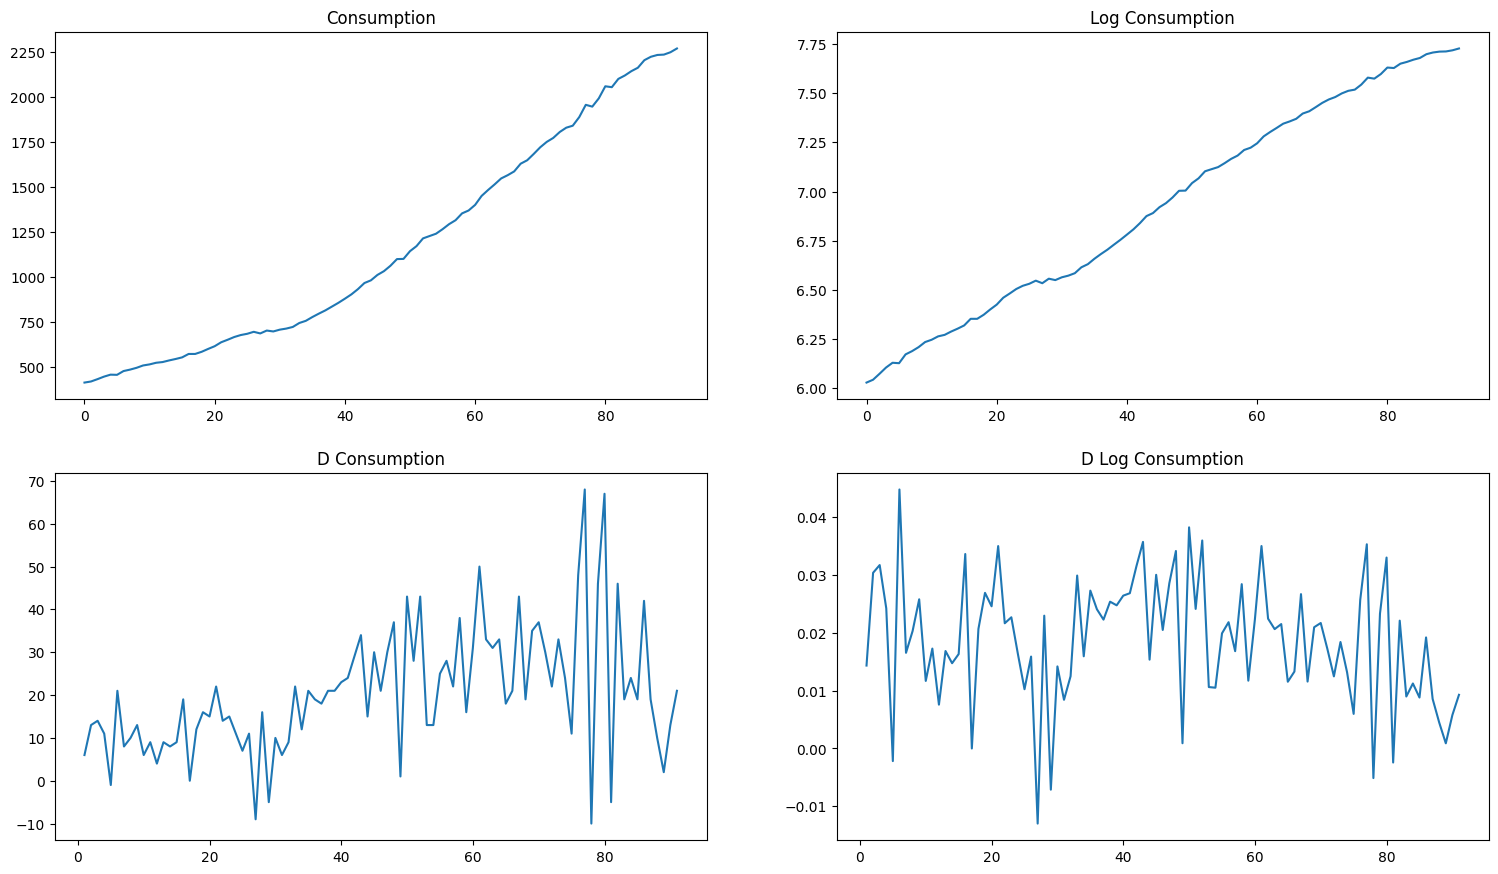

In [79]:
url_4 = "http://www.jmulti.de/download/datasets/German_consumption.dat"
df_4  = pd.read_csv(url_4, on_bad_lines='skip', encoding='cp1252').iloc[:,:1]
df_4 = df_4.iloc[:,0].str.split()[6:]

df = pd.DataFrame()
df["Quarterly Consumption"] = [float(element) for element in df_4.index]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5, forward=True)
x = list(df.index)
axs[0, 0].plot(x, df.values)
axs[0, 0].set_title('Consumption')

axs[0, 1].plot(x, df.apply(np.log).values)
axs[0, 1].set_title('Log Consumption')

axs[1, 0].plot(x, (df - df.shift()).values)
axs[1, 0].set_title('D Consumption')

axs[1, 1].plot(x, (df.apply(np.log) - df.apply(np.log).shift()))
axs[1, 1].set_title('D Log Consumption')

df_raw = df
df_log = df.apply(np.log)
df_serie = df.apply(np.log) - df.apply(np.log).shift().dropna()
df_serie.dropna(inplace = True)
df_log.dropna(inplace = True)
df.dropna(inplace = True)

#### Step 2: Plotting ACF, PACF and Spectral Density
We can analyze the sample ACF and PACF of our time serie to conclude if it aligns well with true ACF or PACF for $AR(p)$ or $MA(r)$ processes for example.

##### Recall!

- True ACF of a __pure MA process__ have a cutoff point corresponding to MA order, PACF taper off. 
- True ACF of a __pure AR process__ taper off, PACF have a cutoff point corresponding to AR order. 

_Pensar la logica detras de esto al menos para procesos $AR(p)$. La autocorrelacion corresponde a cuanto una variable y una lageada dependen la una de la otra y evolucionan de manera conjunta. Esta claro que si es un proceso $AR(p)$ las variables iran dependiendo las unas con las otras ya que parte de una variable es otro valor anterior de esta. Ver la PACF de lag $h$ como el coeficiente en $AR(p)$, esta claro que se va directo a cero una vez que el orden ya no esta tomado en consideracion. Por ejemplo si nuestro proceso en cuestion es un $AR(4)$, la PACF a partir de 4 es 0._

Here, __we will focus on log consumption and call it $y_t$ because of a more stable variance__.

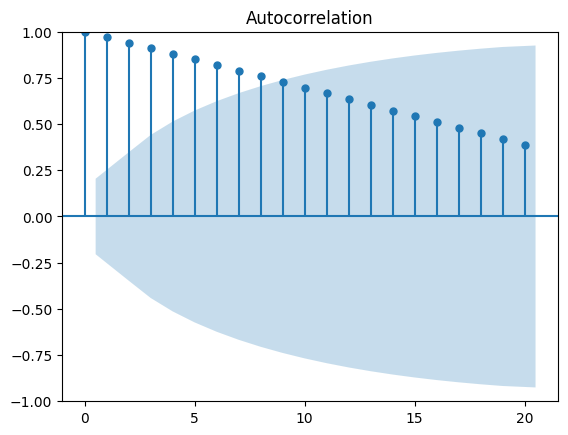

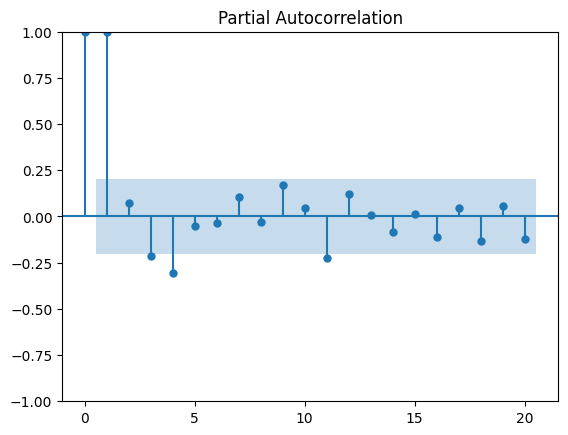

In [80]:
acf = plot_acf(df_log, lags = 20)
pacf = plot_pacf(df_log, lags = 20, method = "ols")

We see the __autocorrelation decay slowly__ which may be the signal that the representation of the AR process as an infinite sum of errors may not converge. Possible unit root, unstable process. 



In [81]:
def spectral_density(time_series, lambda_, truncation_period):
    weights = [1 - j/truncation_period for j in range(truncation_period)]
    autocorrelations = []
    for j in range(truncation_period):
        autocorrelations.append(time_series.autocorr(lag=j))
    output = 1/(2*math.pi)*(weights[0]*autocorrelations[0] + 2*sum([weights[j]*autocorrelations[j]*math.cos(lambda_*j) for j in range(1, truncation_period)]))
    return output
        

Text(0.5, 1.0, 'Barlett Window Estimator - Spectral Density Function')

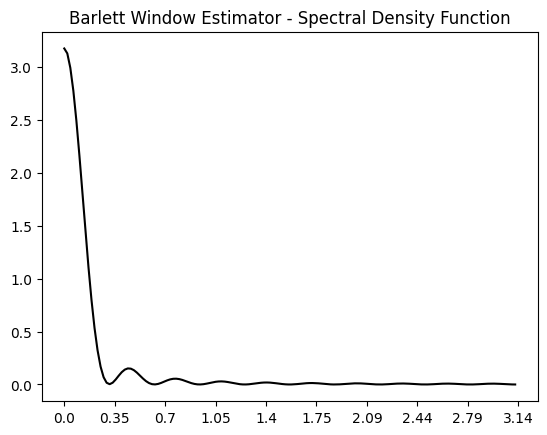

In [82]:
spectre = [spectral_density(df_log.squeeze(), element, 20) for element in np.linspace(0, math.pi, num = 150)]
plt.plot(spectre, color='black')
xi = np.linspace(0, math.pi, num = 10)
xi = [round(element, 2) for element in xi]
plt.xticks(np.linspace(0, 150, num = 10), xi)
plt.title("Barlett Window Estimator - Spectral Density Function")

##### Summary

We have a clear trend in $y_t$, you just havve to look at the graph plotted on the first step. Also, having a slowly decreasing autocorrelation function seems to indicate the presence of a unit root. 

<u>Next Step:</u> Perform some stationarity/unit root tests (aufmented Dickey-Fuller and KPSS). 

In [93]:
p_value = adfuller(df_log.iloc[:, 0].tolist())[1]
threshold = adfuller(df_log.iloc[:, 0].tolist())[4]['5%']
print("The p-Value of ADF test is: ", p_value)
print("Threshold value to consider non-stationarity: ", adfuller(df_log.iloc[:, 0].tolist())[4]['5%'])

if p_value >= threshold: 
    print("NON STATIONARITY")
else: 
    print("STATIONARITY")

The p-Value of ADF test is:  0.7483924696708442
Threshold value to consider non-stationarity:  -2.894989819214876
NON STATIONARITY


-2.894989819214876